In [1]:
from pyspark import SparkContext
import pandas as pd

In [8]:
sc = sc = SparkContext()

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import re
import csv
from datetime import datetime
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt


# pip install workalendar
# https://github.com/novafloss/workalendar
from workalendar.europe import Italy

In [4]:
cal = Italy()

def def_is_holiday(dt_obj):
    if(cal.is_working_day(dt_obj)):
        return 0
    else:
        return 1

In [5]:
row = namedtuple("prodotto", ['zona','area','sottoarea','categoria','timestamp','giorno_della_settimana', 'giorno_del_mese',
                              'giorno_dell_anno', 'mese', 'anno','festivo','vendite'])

In [6]:
def do_parse(x):
    # Oggetto Datetime
    dt_obj = datetime.strptime(str(x[4]), '"%Y-%m-%d"')
    
    return row(
        zona = int(re.sub("[^0-9]", "", str(x[0]))),
        area = int(re.sub("[^0-9]", "", x[1])),
        sottoarea = int(re.sub("[^0-9]", "", x[2])),
        categoria = int(re.sub("[^0-9]", "", x[3])),
        timestamp = int(dt_obj.strftime("%s")),
        giorno_della_settimana = int(dt_obj.weekday()),
        giorno_del_mese = int(dt_obj.weekday()),
        giorno_dell_anno = int(dt_obj.timetuple().tm_yday),
        mese = int(dt_obj.strftime("%m")),
        anno = int(dt_obj.strftime("%Y")),
        festivo = def_is_holiday(dt_obj),
        vendite = int(x[5])
        )

def parse(sc,filepath):
    rawRdd = sc.textFile(filepath)
    
    header = rawRdd.first()

    # Togliamo l'header
    rawRdd = rawRdd.filter(lambda x: x != header)

    # Togliamo le righe vuote
    rawRdd = rawRdd.filter(lambda x: x != "")
    
    return rawRdd.map(lambda x: x.split(",")).map(lambda x: do_parse(x))

In [9]:
rdd = parse(sc,"dataset_polimi.csv")
rdd.take(1)

[prodotto(zona=1, area=1, sottoarea=5, categoria=1, timestamp=1388530800, giorno_della_settimana=2, giorno_del_mese=2, giorno_dell_anno=1, mese=1, anno=2014, festivo=1, vendite=0)]

Data Analysis
--

Zone
----

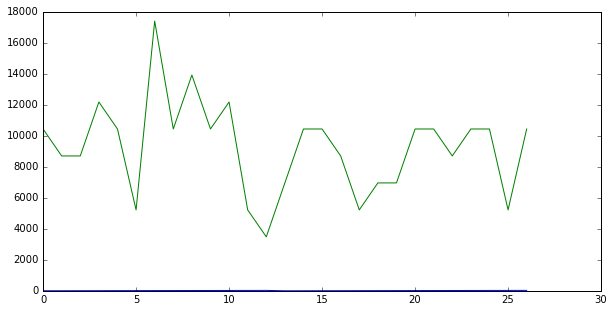

In [10]:
fig = plt.figure(figsize=(10,5))
zone = (rdd.map(lambda x: (x.zona,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(zone)

Aree
---

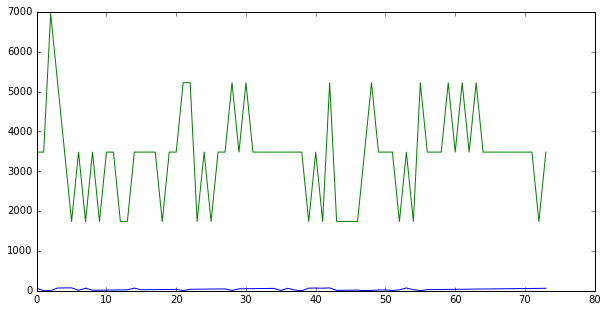

In [11]:
fig = plt.figure(figsize=(10,5))
aree = (rdd.map(lambda x: (x.area,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(aree)

Categorie
---

In [22]:
categorie = (rdd.map(lambda x: (x.categoria,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
categorie

[(1, 125280), (2, 125280)]

Settimana
---

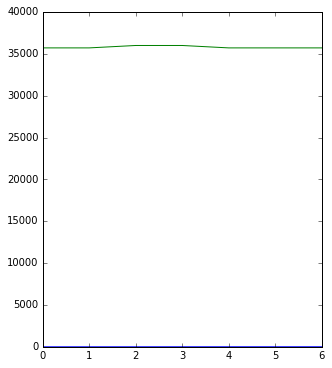

In [93]:
fig = plt.figure(figsize=(5,6))
giorni = (rdd.map(lambda x: (x.giorno_della_settimana,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(giorni)

# Pandas
if you cannot stay without it

In [12]:
collected_rdd = rdd.collect()

In [13]:
df = pd.DataFrame.from_records(collected_rdd,columns = ['zona','area','sottoarea','categoria','timestamp','giorno_della_settimana', 'giorno_del_mese',
                              'giorno_dell_anno', 'mese', 'anno','festivo','vendite'])

In [64]:
# df = df.drop('timestamp',1)

In [139]:
locations[-5:]

,sottoarea,lat,lon,citta,provincia,regione,zona_italia,isola,abitanti,min_distanza,densita
139,141,45.070842,11.878753,Villadose,RO,VEN,Nord,0,5099,25849,0
140,142,45.488347,12.170846,Spinea,VE,VEN,Nord,0,27927,21255,0
141,143,45.330459,12.330348,Venezia,VE,VEN,Nord,0,263352,21536,0
142,144,45.421123,11.026968,Verona,VR,VEN,Nord,0,258765,41067,0
143,145,45.597255,11.502944,Costabissara,VI,VEN,Nord,0,7436,32295,0


In [15]:
locations = pd.read_csv('gps_processed.csv',index_col=0)

In [ ]:
lista_sottoaree = list(locations['sottoarea'])

In [98]:
province_dict = dict()

In [43]:
lista_province = list(locations['provincia']) # mappa ad ogni sottoarea una provincia

In [99]:
for i,s in enumerate(lista_sottoaree):
    province_dict[s] = lista_province[i]

In [103]:
province = set(locations['provincia']) # insieme di tutte le province

In [106]:
sottoaree = list(df['sottoarea']) # mappa ad ogni vendita una sottoarea

In [107]:
bin_dict = dict()

for p in province:
    bin_dict[p] = [int((province_dict[sottoaree[i]] == p)) for i in range(len(sottoaree))]

In [121]:
for d in bin_dict:
    df[d] = pd.Series(bin_dict[d])

In [129]:
df.to_csv('dataset_polimi_with_province.csv',sep = ',')

In [133]:
province_dict[143]

'VE'

In [134]:
province_dict[145]

'VI'

In [138]:
df.ix[df['sottoarea'] == 143]['VE']

182700    1
182701    1
182702    1
182703    1
182704    1
182705    1
182706    1
182707    1
182708    1
182709    1
182710    1
182711    1
182712    1
182713    1
182714    1
182715    1
182716    1
182717    1
182718    1
182719    1
182720    1
182721    1
182722    1
182723    1
182724    1
182725    1
182726    1
182727    1
182728    1
182729    1
         ..
184410    1
184411    1
184412    1
184413    1
184414    1
184415    1
184416    1
184417    1
184418    1
184419    1
184420    1
184421    1
184422    1
184423    1
184424    1
184425    1
184426    1
184427    1
184428    1
184429    1
184430    1
184431    1
184432    1
184433    1
184434    1
184435    1
184436    1
184437    1
184438    1
184439    1
Name: VE, dtype: int64